In [89]:
%load_ext autoreload
%autoreload 2

from SO3 import so3_diffuser, SO3Algebra
from R3 import r3_diffuser
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.spatial.transform import Rotation as Rot
import math
import math
import random
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as Rot
from mpl_toolkits.mplot3d import Axes3D
import geoopt
from geoopt.optim import (RiemannianAdam)
Stiefel = geoopt.Stiefel()
from matplotlib import cm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


THIS CODE IS BASED ON THE FOLLOWING TWO PAPERS: 
DENOISING DIFFUSION PROBABILISTIC MODELS ON SO(3) FOR ROTATIONAL ALIGNMENT by LEACH et al
SE(3) diffusion model with application to protein backbone generation by Yim et al 

Operations on SO(3) have been taken from: https://github.com/qazwsxal/diffusion-extensions

In [59]:
import numpy as np
import torch
from scipy.spatial.transform import Rotation as SciRot

so3 = SO3Algebra()

def test_batch(batch_size: int = 8, dtype=torch.float32, device='cpu'):
    """
    Check that log_map, get_v, and exp_map agree with SciPy on a batch
    of random rotation matrices.
    """
    # ----------------------------------------------------------
    # 1. generate a batch of random rotations via SciPy
    # ----------------------------------------------------------
    R_np = SciRot.random(batch_size).as_matrix()          # (B,3,3)
    R_t  = torch.tensor(R_np, dtype=dtype, device=device) # (B,3,3)

    # ----------------------------------------------------------
    # 2. SO(3)-algebra forward + inverse
    # ----------------------------------------------------------
    S_skew   = so3.log_map(R_t)                 # (B,3,3)
    v_tensor = so3.get_v(S_skew)                # (B,3)
    R_recon  = so3.exp_map(v_tensor)            # (B,3,3)

    # ----------------------------------------------------------
    # 3. SciPy ground truth axis-angle vectors
    # ----------------------------------------------------------
    v_gt = SciRot.from_matrix(R_np).as_rotvec() # (B,3)

    # ----------------------------------------------------------
    # 4. diagnostics
    # ----------------------------------------------------------
    v_err  = torch.linalg.norm(
        torch.tensor(v_gt, dtype=dtype, device=device) - v_tensor, dim=-1)
    R_err  = torch.linalg.norm(
        torch.tensor(R_np, dtype=dtype, device=device) - R_recon, dim=(-2, -1))

    print("Axis-angle error ‖v_gt − v_pred‖ per sample:")
    for i, e in enumerate(v_err.cpu().numpy()):
        print(f"  sample {i:02d}: {e:.3e}")

    print("\nFrobenius error ‖R − exp_map(v_pred)‖_F per sample:")
    for i, e in enumerate(R_err.cpu().numpy()):
        print(f"  sample {i:02d}: {e:.3e}")

    print("\nSummary:")
    print(f"  max  axis-angle error: {v_err.max():.3e}")
    print(f"  mean axis-angle error: {v_err.mean():.3e}")
    print(f"  max  Frobenius error:  {R_err.max():.3e}")
    print(f"  mean Frobenius error: {R_err.mean():.3e}")

# ---------------------------------------------------------------------

test_batch(10)


Axis-angle error ‖v_gt − v_pred‖ per sample:
  sample 00: 2.666e-07
  sample 01: 1.366e-07
  sample 02: 0.000e+00
  sample 03: 1.788e-07
  sample 04: 1.333e-07
  sample 05: 6.053e-08
  sample 06: 1.201e-07
  sample 07: 6.529e-07
  sample 08: 1.192e-07
  sample 09: 3.210e-07

Frobenius error ‖R − exp_map(v_pred)‖_F per sample:
  sample 00: 3.213e-07
  sample 01: 1.673e-07
  sample 02: 2.816e-07
  sample 03: 3.954e-07
  sample 04: 2.988e-07
  sample 05: 8.752e-08
  sample 06: 3.312e-07
  sample 07: 6.137e-07
  sample 08: 1.080e-07
  sample 09: 2.566e-07

Summary:
  max  axis-angle error: 6.529e-07
  mean axis-angle error: 1.989e-07
  max  Frobenius error:  6.137e-07
  mean Frobenius error: 2.861e-07


In [81]:
import torch, torch.nn as nn
from typing import Literal

class SE3MLP(nn.Module):
    """
    Joint SE(3) diffusion network.

    Args
    ----
    d_model : width of the time-embedding (and hidden width for *joint* / *split*)
    head    : 'joint' | 'split' | 'residual'
              • joint   – single MLP that outputs [v_rot, v_trans]           (old default)
              • split   – separate MLPs for rotation and translation noise  (old 'split')
              • residual– deeper residual MLP with separate heads           (new robust)
    hidden_dim : width inside the residual head (ignored for other heads)
    n_blocks    : number of residual blocks      (ignored for other heads)
    dropout     : dropout prob inside residual blocks
    """
    HeadType = Literal['joint', 'split', 'residual']

    def __init__(
        self,
        d_model: int = 256,
        head: HeadType = 'joint',
        hidden_dim: int = 256,
        n_blocks: int = 3,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.head = head

        # ---------- time embedding ----------
        self.time_embed = nn.Sequential(
            nn.Linear(1, d_model),
            nn.SiLU()
        )

        # ---------- JOINT head (old) ----------
        self.mlp_joint = nn.Sequential(
            nn.Linear(12 + d_model, d_model),
            nn.SiLU(),
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.SiLU(),
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 6)
        )

        # ---------- SPLIT heads (old 'split') ----------
        self.mlp_rot = nn.Sequential(
            nn.Linear(9 + d_model, d_model),
            nn.SiLU(),
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.SiLU(),
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 3)
        )
        self.mlp_trans = nn.Sequential(
            nn.Linear(3 + d_model, d_model),
            nn.SiLU(),
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.SiLU(),
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 3)
        )

        # ---------- RESIDUAL head (new, more robust) ----------
        if head == 'residual':
            self.residual_head = ResidualSE3Head(
                d_model=d_model,
                hidden_dim=hidden_dim,
                n_blocks=n_blocks,
                dropout=dropout
            )

    # ---- forward helpers --------------------------------------------------

    def _forward_joint(self, R_t, T_t, t):
        B = R_t.size(0)
        flat_rot = R_t.reshape(B, 9)
        feats    = torch.cat([flat_rot, T_t], dim=1)              # (B,12)
        t_emb    = self.time_embed(t.view(B, 1).float())          # (B,d_model)
        return self.mlp_joint(torch.cat([feats, t_emb], dim=1))   # (B,6)

    def _forward_split(self, R_t, T_t, t):
        B = R_t.size(0)
        flat_rot = R_t.reshape(B, 9)
        t_emb    = self.time_embed(t.view(B, 1).float())

        v_rot   = self.mlp_rot(torch.cat([flat_rot, t_emb], dim=1))
        v_trans = self.mlp_trans(torch.cat([T_t,     t_emb], dim=1))
        return torch.cat([v_rot, v_trans], dim=1)                 # (B,6)

    # -----------------------------------------------------------------------

    def forward(self, R_t: torch.Tensor, T_t: torch.Tensor, t: torch.Tensor):
        if self.head == 'joint':
            return self._forward_joint(R_t, T_t, t)
        elif self.head == 'split':
            return self._forward_split(R_t, T_t, t)
        elif self.head == 'residual':
            B = R_t.size(0)
            flat_rot = R_t.reshape(B, 9)
            feats    = torch.cat([flat_rot, T_t], dim=1)          # (B,12)
            t_emb    = self.time_embed(t.view(B, 1).float())      # (B,d_model)
            return self.residual_head(feats, t_emb)               # (B,6)
        else:
            raise ValueError(f"Unknown head style '{self.head}'")


# ---------------------------------------------------------------------------
# Robust residual head used when head='residual'
# ---------------------------------------------------------------------------

class ResidualSE3Head(nn.Module):
    def __init__(self, d_model: int, hidden_dim: int, n_blocks: int, dropout: float):
        super().__init__()
        self.input_proj = nn.Linear(12 + d_model, hidden_dim)

        blocks = []
        for _ in range(n_blocks):
            blocks.append(
                nn.Sequential(
                    nn.LayerNorm(hidden_dim),
                    nn.SiLU(),
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.Dropout(dropout)
                )
            )
        self.blocks = nn.ModuleList(blocks)

        self.out_rot   = nn.Linear(hidden_dim, 3)
        self.out_trans = nn.Linear(hidden_dim, 3)

    def forward(self, x_flat: torch.Tensor, t_emb: torch.Tensor):
        x = self.input_proj(torch.cat([x_flat, t_emb], dim=1))
        for blk in self.blocks:
            x = x + blk(x)                    # residual connection
        rot   = self.out_rot(x)
        trans = self.out_trans(x)
        return torch.cat([rot, trans], dim=1)

In [82]:
class se3_diffuser:
    def __init__(self, T, batch_size=64, device="cpu", betas=None, split = False):
        self.device      = torch.device(device)
        self.batch_size  = batch_size

        self.so3 = so3_diffuser(T, batch_size, betas, device=device)
        self.r3  = r3_diffuser(T, batch_size, betas, device=device)

        self.model = SE3MLP(
            head='residual',       # use the new residual architecture
            d_model=256,           # time embedding width (same as before unless you want to change it)
            hidden_dim=256,        # hidden width inside residual MLP
            n_blocks=3,            # number of residual blocks
            dropout=0.1            # dropout rate
        ).to(self.device)
        self.opt   = torch.optim.Adam(self.model.parameters(), lr=1e-4)

        self.T = T    
        self.split = split

    def batch_se3(self, R_clean, T_clean, epoch = None):
        """
        R_clean : (B,3,3)  – GT rotations
        T_clean : (B,3)    – GT translations
        """
        self.model.train()
        B = R_clean.size(0)

        t = torch.randint(1, self.T, (1,), device=self.device).item()

        R_noise, v_noise = self.so3.generate_noise(t)         
           
        T_noise          = self.r3.generate_noise((3,), t)      

        noise = T_noise / torch.sqrt(1 - self.r3.alpha_bars[int(t)]) 
        R_t = self.so3.add_noise(R_clean, R_noise, t)
        T_t = self.r3.add_noise(T_clean, T_noise, t)
        pred = self.model(R_t, T_t, torch.full((B,1), t, device=self.device))
        pred_rot, pred_trans = pred[:, :3], pred[:, 3:]
        
        if(not epoch == None and epoch % 20000 == 0): 
            print("Noise_rot", v_noise) 
            print("Pred_rot", pred_rot)
            print("Noise_translation", noise)
            print("Pred_translation", pred_trans)

        loss = 0.5 * ((pred_rot - v_noise)**2).mean() + 0.5 * ((pred_trans - T_noise)**2).mean()

        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        return loss.item()


    @torch.no_grad()
    def sample(self, N=1, guidance=False, optim_steps=1, cost=None):
        R_t = torch.stack([ torch.from_numpy(Rot.random().as_matrix()).float() for _ in range(N) ]).to(self.device)
        T_t = torch.randn((N, 3), device=self.device)

        for t in reversed(range(1, self.T)):
            # predict noise
            eps = self.model(R_t, T_t,
                             torch.full((N,1), t, device=self.device))
            eps_rot, eps_trans = eps[:, :3], eps[:, 3:]

            # rotation reverse step
            R_t = self.so3._se_sample_batch(R_t, t, eps_rot,
                                            guidance, optim_steps, cost)[1]

            # translation reverse step
            T_t = self.r3._eu_sample_batch(T_t, t, eps_trans,
                                           guidance, optim_steps, cost)
        return R_t, T_t
    

tensor([[ 0.7071,  0.0000,  0.7071],
        [ 0.0000,  1.0000,  0.0000],
        [-0.7071,  0.0000,  0.7071]])
tensor([[ 0.7071, -0.0000, -0.7071],
        [ 0.0000,  1.0000, -0.0000],
        [ 0.7071,  0.0000,  0.7071]])
[pair SE(3)] epoch 10000 | loss 0.031485
Noise_rot tensor([[-0.0441, -0.0312,  0.5891],
        [ 0.3168,  0.3237,  0.2418],
        [-0.2165, -0.4491, -0.0061],
        [ 0.0686,  0.4167,  0.4439],
        [-0.4839, -0.5001, -0.5542],
        [ 0.1065,  0.6107, -0.3240],
        [-0.5094,  0.1614, -0.3695],
        [-0.0205,  0.0706,  0.5015],
        [ 0.7430,  0.1088, -0.5132],
        [ 0.4329,  0.4032, -0.1010],
        [-0.6237, -0.3403, -0.0015],
        [ 0.7064,  0.1050, -0.1784],
        [-0.2912,  0.2496, -0.7591],
        [-0.0204,  0.0624, -0.6186],
        [-0.0516, -0.5986,  0.9460],
        [ 0.1621, -0.5776, -0.1151]])
Pred_rot tensor([[-5.1200e-01,  5.4756e-01,  1.0763e+00],
        [-1.1303e-03,  2.3153e-01,  6.8395e-01],
        [-5.4301e-01, -1.

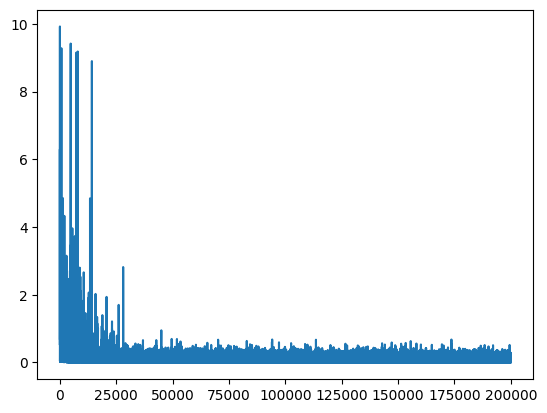

In [83]:
import torch 

# --------------------------------------------------------------- #
# Build the two-pose “dataset” using SciPy for rock-solid rotations
# --------------------------------------------------------------- #
def build_pose_dataset(device):
    """
    Returns a list [(R1,T1), (R2,T2)] where
      • Pose-1: 45° about +x,  translation (1, 0, 0)
      • Pose-2: 90° about +y,  translation (0, 0, −1)
    SciPy does the heavy lifting for rotation construction.
    """
    # Pose 1  (rotvec = axis * angle)
    rotvec1 = np.array([0.0, 1.0, 0.0]) * (np.pi / 4)          # 45° about x
    R1 = torch.tensor(Rot.from_rotvec(rotvec1).as_matrix(),
                      dtype=torch.float32, device=device)
    print(R1)
    T1 = torch.tensor([1., 0., 0.], dtype=torch.float32, device=device)

    # Pose 2
    rotvec2 = np.array([0.0, -1.0, 0.0]) * (np.pi / 4)          # 90° about y
    R2 = torch.tensor(Rot.from_rotvec(rotvec2).as_matrix(),
                      dtype=torch.float32, device=device)
    print(R2)
    T2 = torch.tensor([0., 0., -1.], dtype=torch.float32, device=device)

    return [(R1, T1), (R2, T2)]  # length-2 list of (R, T) tuples

def train_synthetic_pairs(diffuser, epochs=100, log_every=10000):
    B      = diffuser.batch_size
    device = diffuser.device
    dataset = build_pose_dataset(device)   # now SciPy-powered
    K = len(dataset)                       # =2

    losses = []
    for ep in range(1, epochs + 1):
        idx = torch.randint(high=K, size=(B,), device=device)   # (B,)
        Rs, Ts = zip(*[dataset[i] for i in idx.cpu().tolist()])
        Rs = torch.stack(Rs)    # (B,3,3)
        Ts = torch.stack(Ts)    # (B,3)

        loss = diffuser.batch_se3(Rs, Ts, ep)
        if(loss <= 10): 
            losses.append(loss)

        if ep % log_every == 0:
            print(f"[pair SE(3)] epoch {ep:4d} | loss {loss:.6f}")

    return losses

diffuser = se3_diffuser(T=100, batch_size=16, device="cpu", split = False)

# Step 2: Train on synthetic two-fixed-pose dataset
losses = train_synthetic_pairs(diffuser, epochs = 200000)

plt.plot(losses)

In [84]:
R, T = diffuser.sample()
R = R.squeeze(0)
print("R", R)
print("T", T)

print(R.T@R)


R tensor([[ 0.6672,  0.0376, -0.7439],
        [-0.0414,  0.9991,  0.0133],
        [ 0.7437,  0.0219,  0.6682]])
T tensor([[ 0.0106,  0.0341, -0.9747]])
tensor([[ 1.0000e+00, -3.4877e-09, -1.2457e-07],
        [-3.4877e-09,  1.0000e+00, -9.4918e-09],
        [-1.2457e-07, -9.4918e-09,  1.0000e+00]])


/Users/michaeljacob/R3.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_prev = (1 / torch.sqrt(torch.tensor(self.alphas[t]))) * (x_t - v_tensor) + v_noise


In [90]:
def plot_samples(num_samples=100, guidance=False, optim_steps=1, cost=None):
    rot_axes   = []
    trans_axes = []

    for _ in range(num_samples):
        R_sample, t_sample = diffuser.sample()      # R ∈ ℝ3×3 , t ∈ ℝ3
        R_sample = R_sample.squeeze(0)              # (3,3)
        t_sample = t_sample.squeeze(0)              # (3,)

        # ---- rotation axis ---------------------------------------------------
        omega  = Rot.from_matrix(R_sample).as_rotvec()
        theta  = np.linalg.norm(omega)
        if theta > 1e-5:
            axis = omega / theta
        else:                                       # identity – pick arbitrary axis
            axis = np.array([1.0, 0.0, 0.0])
        print(axis)
        rot_axes.append(axis)

        # ---- translation “axis” (unit-vector) --------------------------------
        trans_axis = t_sample / (np.linalg.norm(t_sample) + 1e-8)
        trans_axes.append(trans_axis)

    rot_axes   = np.stack(rot_axes)    # (N,3)
    trans_axes = np.stack(trans_axes)  # (N,3)

    # -------------------- plotting --------------------------------------------
    fig = plt.figure(figsize=(6, 6))
    ax  = fig.add_subplot(111, projection='3d')

    ax.scatter(rot_axes[:,0],   rot_axes[:,1],   rot_axes[:,2], c='blue',  s=20, label='rotation axis')
    ax.scatter(trans_axes[:,0], trans_axes[:,1], trans_axes[:,2], c='red',   s=20, label='translation axis')

    # unit-sphere wireframe for reference
    u = np.linspace(0, 2*np.pi, 100)
    v = np.linspace(0, np.pi,   100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_wireframe(x, y, z, color='gray', alpha=0.2)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_box_aspect([1, 1, 1])
    ax.legend(loc="upper right")
    plt.show()

    return theta, rot_axes

def plot_samples_alt(num_samples=100, guidance=False, optim_steps=1, cost=None):
    rot_axes, trans_axes = [], []

    for _ in range(num_samples):
        R_sample, t_sample = diffuser.sample()
        R_sample, t_sample = R_sample.squeeze(0), t_sample.squeeze(0)

        # --- rotation axis ----------------------------------------------------
        omega = Rot.from_matrix(R_sample).as_rotvec()
        theta = np.linalg.norm(omega)
        axis  = omega / theta if theta > 1e-5 else np.array([1., 0., 0.])
        rot_axes.append(axis)

        # --- translation “axis” (unit-vector) ---------------------------------
        trans_axes.append(t_sample / (np.linalg.norm(t_sample) + 1e-8))

    rot_axes, trans_axes = np.stack(rot_axes), np.stack(trans_axes)

    # -------------------- plotting -------------------------------------------
    fig = plt.figure(figsize=(7, 7))
    ax  = fig.add_subplot(111, projection='3d')

    # unique colour for each pair
    cmap   = cm.get_cmap("tab20", num_samples)
    colours = cmap(np.arange(num_samples))

    for i, colour in enumerate(colours):
        # rotation axis   – marker ^ (triangle)
        ax.scatter(*rot_axes[i],  c=[colour], marker='^', s=50, label=None)
        # translation axis – marker o (circle)
        ax.scatter(*trans_axes[i], c=[colour], marker='o', s=50, label=None)
        # optional: line linking the two
        ax.plot([rot_axes[i,0], trans_axes[i,0]],
                [rot_axes[i,1], trans_axes[i,1]],
                [rot_axes[i,2], trans_axes[i,2]],
                c=colour, alpha=0.5, linewidth=1)

    # reference unit sphere
    u, v = np.linspace(0, 2*np.pi, 60), np.linspace(0, np.pi, 30)
    x, y = np.outer(np.cos(u), np.sin(v)), np.outer(np.sin(u), np.sin(v))
    z    = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_wireframe(x, y, z, color='gray', alpha=0.15, linewidth=0.3)

    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.set_box_aspect([1,1,1])
    plt.tight_layout()
    plt.show()

    # return both arrays if you need them later
    return rot_axes, trans_axes

[ 0.01964877  0.99815898 -0.05738092]
[ 0.02201341  0.99926285 -0.03145096]
[ 0.03094334 -0.99802573 -0.05465491]
[ 0.04998727 -0.99731823 -0.0534568 ]
[ 0.04338337  0.99796376 -0.04675709]
[ 0.07953395  0.99644637 -0.02773039]
[ 0.00542447 -0.99786479 -0.06508787]
[ 0.01282149  0.99940334 -0.03207152]
[ 0.01107847 -0.99847659 -0.05405343]
[ 0.01982257 -0.99775024 -0.06404315]
[ 0.05517358 -0.99610919 -0.06871942]
[-0.00120423 -0.99882908 -0.04836338]
[ 0.01808757  0.99814777 -0.05808504]
[ 0.03338749 -0.99917302 -0.0232068 ]
[ 0.04224723  0.99816579 -0.04336159]
[ 0.02980987  0.99853955 -0.04505714]
[ 0.02540515 -0.99724364 -0.06971155]
[ 0.02003777 -0.99933701 -0.03039776]
[ 0.02485192 -0.99937509 -0.02513589]
[ 0.03005087 -0.99890902 -0.03574512]
[ 0.02654389 -0.9994455  -0.02010249]
[ 0.02557001 -0.99866304 -0.04492546]
[ 0.02345095  0.99650589 -0.08016271]
[ 0.00849766 -0.99899066 -0.04410718]
[ 0.04781804  0.99817565 -0.03686198]
[ 0.03104825  0.99943575 -0.01281336]
[ 0.06248985

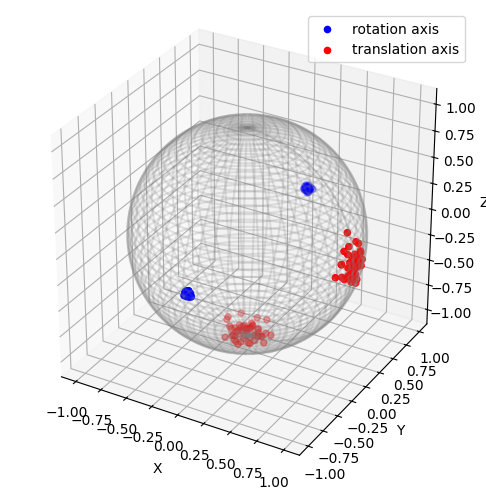

/var/folders/9q/pw8p78j55rvgrvdqkq43f2m00000gn/T/ipykernel_28338/2302400441.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap   = cm.get_cmap("tab20", num_samples)


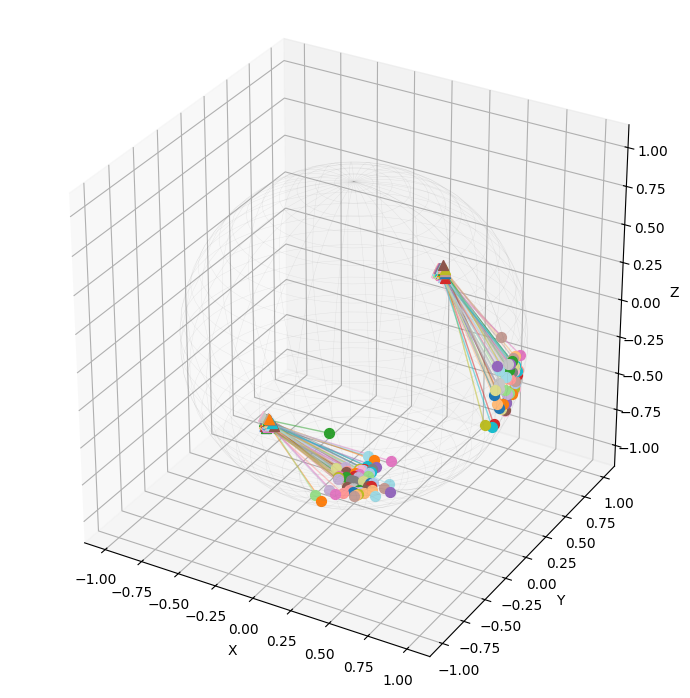

(array([[ 3.44563002e-02,  9.99073753e-01, -2.57759343e-02],
        [ 4.94849899e-02,  9.97445019e-01, -5.15234965e-02],
        [ 3.27307806e-02, -9.98561796e-01, -4.24621686e-02],
        [ 1.26640017e-02, -9.95775822e-01, -9.09402840e-02],
        [ 2.11437326e-02,  9.98528667e-01, -4.99343962e-02],
        [ 2.18144006e-02, -9.98625817e-01, -4.76509192e-02],
        [ 3.18284332e-04, -9.96844257e-01, -7.93815158e-02],
        [ 2.65265433e-02, -9.97982939e-01, -5.76749142e-02],
        [ 3.95671513e-02,  9.95969918e-01, -8.04882836e-02],
        [ 1.88307306e-02, -9.99049145e-01, -3.93218637e-02],
        [ 9.99432390e-03, -9.99040270e-01, -4.26456658e-02],
        [ 2.91577939e-02, -9.97741098e-01, -6.05187978e-02],
        [ 4.76922768e-02,  9.98056837e-01, -4.00998415e-02],
        [ 3.28740207e-02,  9.98549560e-01, -4.26388833e-02],
        [ 3.44373339e-02, -9.99139955e-01, -2.30958867e-02],
        [ 1.80587067e-02, -9.99335689e-01, -3.16554063e-02],
        [ 2.04802802e-03

In [91]:
""" GOAL DISTRIBUTION
    # Pose 1  (rotvec = axis * angle)
    rotvec1 = np.array([0.0, 1.0, 0.0]) * (np.pi / 4)          # 45° about x
    R1 = torch.tensor(Rot.from_rotvec(rotvec1).as_matrix(),
                      dtype=torch.float32, device=device)
    print(R1)
    T1 = torch.tensor([1., 0., 0.], dtype=torch.float32, device=device)

    # Pose 2
    rotvec2 = np.array([0.0, -1.0, 0.0]) * (np.pi / 4)          # 90° about y
    R2 = torch.tensor(Rot.from_rotvec(rotvec2).as_matrix(),
                      dtype=torch.float32, device=device)
    print(R2)
    T2 = torch.tensor([0., 0., -1.], dtype=torch.float32, device=device)
"""
plot_samples(num_samples = 100)

plot_samples_alt(num_samples = 100)